In [127]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [128]:
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import warnings;warnings.filterwarnings("ignore")
import seaborn as sns
import numpy as np
import re
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 20


In [130]:
df = pd.read_csv('/content/drive/MyDrive/DKE/project 1-1/SHR76_20.csv',index_col=0) 

print("sample nb= ",len(df))
print("vars nb= ",len(df.columns))


sample nb=  827219
vars nb=  30


In [131]:
def feature_cleaning(old_df):
  df = old_df.copy(deep = True)
  # Feature Cleaning
  df.insert(1, 'County', df['CNTYFIPS'].map(lambda x : str(x).split(',')[0]), True)
  df.drop("CNTYFIPS",axis = 1, inplace= True) # redundant, onlyy keeping the county part
  df.drop("Ori",axis = 1, inplace= True)  # redundant, contains state + county + agentcy nb
  df.drop("StateName" ,axis = True, inplace=True) # redundant with "State"

  df.insert(3, 'Area',df['MSA'].map(lambda x :  str(x).split(',')[0] ) ,True)
  df.drop('MSA',axis = 1,inplace=True) # rendundant only the state, keeping the metropolitant statistical area
  df['OffAge'].replace(999, np.NaN, inplace=True) # replacing 999 ages with Nan

  # split File Date in Day-Month-Year columns
  nan_indexes = df["FileDate"].isna()
  df['FileDate'].fillna(0,inplace = True)
  df['FileDate'] = df['FileDate'].astype(int)
  df['FileDate'] = df['FileDate'].astype(str)
  df.insert(1, 'File Year', df['FileDate'].map(lambda x : x[len(x)-2:len(x)]), True)
  df.insert(1, 'File Day', df['FileDate'].map(lambda x : x[len(x)-4:len(x)-2]), True)
  df.insert(1, 'File Month', df['FileDate'].map(lambda x : x[0:len(x)-4]), True)
  df.loc[nan_indexes,"File Year"] = np.NaN
  df.loc[nan_indexes,"File Day"] = np.NaN
  df.loc[nan_indexes,"File Month"] = np.NaN
  df.drop("FileDate",axis = 1,inplace = True)

  df.drop("Incident",axis = 1,inplace = True) # incient number of the month, for a specific county useless for our application

  df.drop("Situation",axis = 1,inplace = True) # redundant, info already contained in OffCount and VicCount

  # df.drop("Source",axis = 1,inplace = True)# drop source ? is that information meaningful?
  return df

In [132]:
df = feature_cleaning(df)
df.columns

Index(['County', 'File Month', 'File Day', 'File Year', 'State', 'Agency',
       'Area', 'Agentype', 'Source', 'Solved', 'Year', 'Month', 'ActionType',
       'Homicide', 'VicAge', 'VicSex', 'VicRace', 'VicEthnic', 'OffAge',
       'OffSex', 'OffRace', 'OffEthnic', 'Weapon', 'Relationship',
       'Circumstance', 'Subcircum', 'VicCount', 'OffCount'],
      dtype='object')

In [133]:
df.iloc[:, : 10].head()

,County,File Month,File Day,File Year,State,Agency,Area,Agentype,Source,Solved
ID,,,,,,,,,,
197609001AL00400,Autauga,3,01,80,Alabama,Autauga County,Montgomery,Sheriff,FBI,No
197701001AL00400,Autauga,3,01,80,Alabama,Autauga County,Montgomery,Sheriff,FBI,Yes
197703001AL00400,Autauga,3,01,80,Alabama,Autauga County,Montgomery,Sheriff,FBI,Yes
197703001AL00401,Autauga,3,01,80,Alabama,Prattville,Montgomery,Municipal police,FBI,Yes
197708001AL00400,Autauga,3,01,80,Alabama,Autauga County,Montgomery,Sheriff,FBI,Yes


In [134]:
df.iloc[:,10 : 20].head()

,Year,Month,ActionType,Homicide,VicAge,VicSex,VicRace,VicEthnic,OffAge,OffSex
ID,,,,,,,,,,
197609001AL00400,1976,September,Normal update,Murder and non-negligent manslaughter,30,Male,Black,Unknown or not reported,NaN,Unknown
197701001AL00400,1977,January,Normal update,Murder and non-negligent manslaughter,65,Female,Black,Unknown or not reported,62.0,Male
197703001AL00400,1977,March,Normal update,Murder and non-negligent manslaughter,48,Male,White,Unknown or not reported,52.0,Male
197703001AL00401,1977,March,Normal update,Murder and non-negligent manslaughter,27,Male,Black,Unknown or not reported,22.0,Female
197708001AL00400,1977,August,Normal update,Murder and non-negligent manslaughter,17,Female,Black,Unknown or not reported,21.0,Male


In [135]:
df.iloc[:, 20 : ].head()

,OffRace,OffEthnic,Weapon,Relationship,Circumstance,Subcircum,VicCount,OffCount
ID,,,,,,,,
197609001AL00400,Unknown,Unknown or not reported,Other or type unknown,Relationship not determined,Other,NaN,0,0
197701001AL00400,Black,Unknown or not reported,Other or type unknown,Acquaintance,Brawl due to influence of alcohol,NaN,0,0
197703001AL00400,White,Unknown or not reported,"Handgun - pistol, revolver, etc",Acquaintance,Other arguments,NaN,0,1
197703001AL00401,Black,Unknown or not reported,Shotgun,Husband,Other arguments,NaN,0,0
197708001AL00400,Black,Unknown or not reported,Knife or cutting instrument,Acquaintance,Circumstances undetermined,NaN,0,0


In [136]:
df.columns

Index(['County', 'File Month', 'File Day', 'File Year', 'State', 'Agency',
       'Area', 'Agentype', 'Source', 'Solved', 'Year', 'Month', 'ActionType',
       'Homicide', 'VicAge', 'VicSex', 'VicRace', 'VicEthnic', 'OffAge',
       'OffSex', 'OffRace', 'OffEthnic', 'Weapon', 'Relationship',
       'Circumstance', 'Subcircum', 'VicCount', 'OffCount'],
      dtype='object')

In [137]:
df.dtypes

County           object
File Month       object
File Day         object
File Year        object
State            object
Agency           object
Area             object
Agentype         object
Source           object
Solved           object
Year              int64
Month            object
ActionType       object
Homicide         object
VicAge            int64
VicSex           object
VicRace          object
VicEthnic        object
OffAge          float64
OffSex           object
OffRace          object
OffEthnic        object
Weapon           object
Relationship     object
Circumstance     object
Subcircum        object
VicCount          int64
OffCount          int64
dtype: object

In [138]:
df['Area'].value_counts()

New York-New Jersey-Long Island    63174
Los Angeles-Long Beach             57887
Chicago-Naperville-Joliet          36086
Detroit-Warren-Livonia             26159
Houston-Sugar Land-Baytown         24647
                                   ...  
Logan                                 46
Carson City                           43
Dubuque                               41
Ames                                  30
Rural Massachusetts                    8
Name: Area, Length: 391, dtype: int64

In [139]:
df['Circumstance'].value_counts()

Circumstances undetermined              220836
Other arguments                         212533
Other                                   106983
Robbery                                  61325
Narcotic drug laws                       30724
Other - not specified                    29649
Juvenile gang killings                   25072
Felon killed by police                   18119
Brawl due to influence of alcohol        16307
Argument over money or property          15882
Felon killed by private citizen          14365
All suspected felony type                13686
Lovers triangle                          12582
All other manslaughter by negligence      7341
Burglary                                  6652
Gangland killings                         5958
Brawl due to influence of narcotics       5237
Arson                                     4855
Rape                                      4233
Other negligent handling of gun           4169
Children playing with gun                 1524
Other sex off

In [140]:
for i in df.columns:
    x=df[i].value_counts()
    print(x)

Los Angeles      53346
New York         46472
Cook             30350
Wayne            24792
Harris           21340
                 ...  
Gosper               1
Mora                 1
Gilliam              1
Yukon-Koyukuk        1
Ida                  1
Name: County, Length: 1795, dtype: int64
3     217959
2     111714
4      88291
8      80969
1      66675
9      64857
7      45496
10     37375
11     32851
12     30782
5      24067
6      23673
Name: File Month, dtype: int64
01    123572
30     54532
06     42221
16     32364
10     30808
04     28989
31     28141
18     26635
25     25426
13     23331
14     23050
22     22750
21     22470
05     21407
23     20715
17     20546
12     20500
11     20429
26     20098
29     19918
02     19854
27     19727
19     19238
24     19158
28     18493
09     18332
07     17330
15     16653
08     16445
03     16060
20     15517
Name: File Day, dtype: int64
80    78312
81    32508
93    24970
82    24109
92    23710
94    23525
21    22468
90 

In [142]:
to_print= [ 'Agentype', 'Source',
       'Solved', 'Year', 'Month',
       'Homicide', 'Situation', 'VicAge', 'VicSex', 'VicRace', 'VicEthnic',
       'OffAge', 'OffSex', 'OffRace', 'OffEthnic', 'Weapon', 'Relationship',
       'Circumstance', 'Subcircum', 'VicCount', 'OffCount', 
       'State']

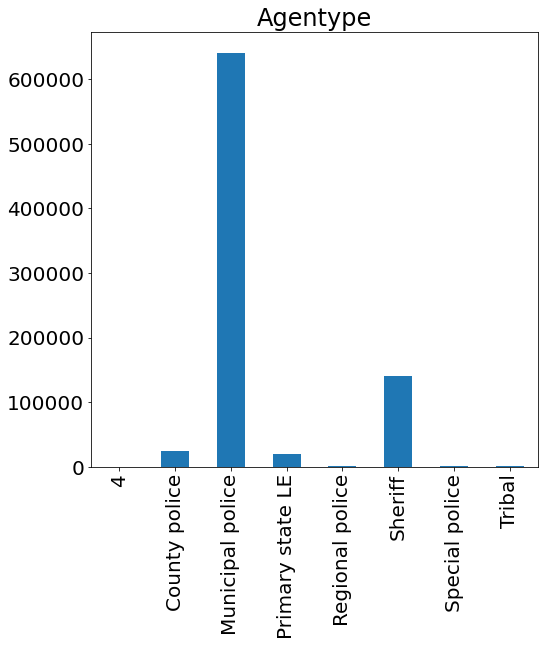

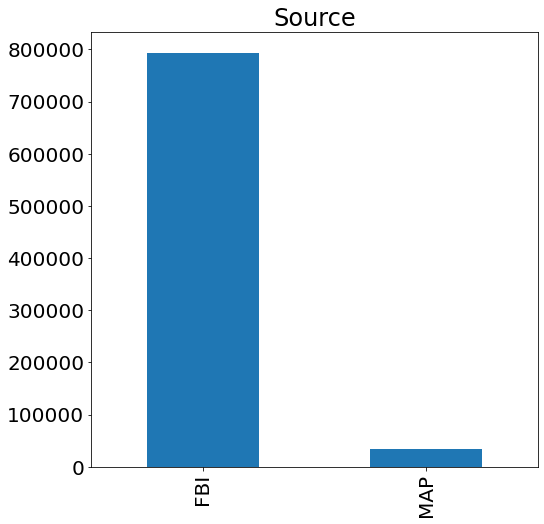

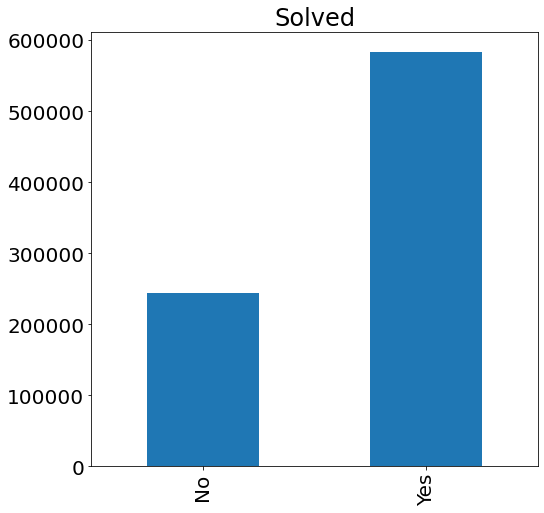

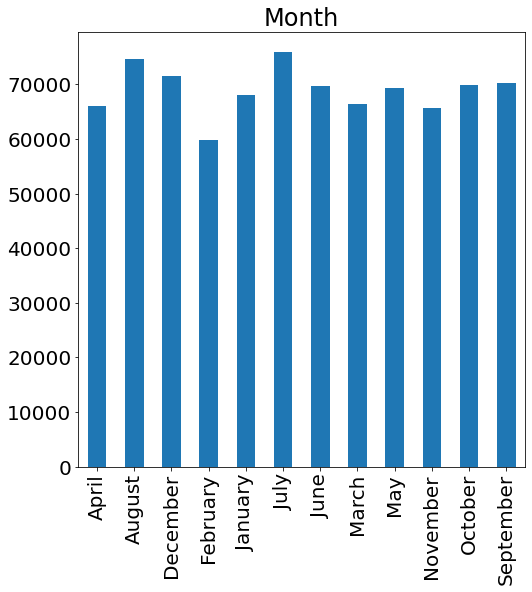

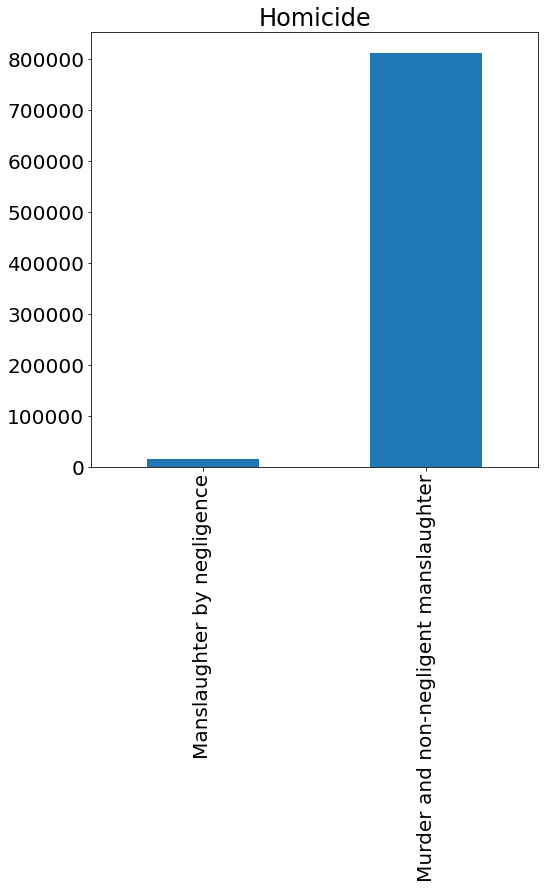

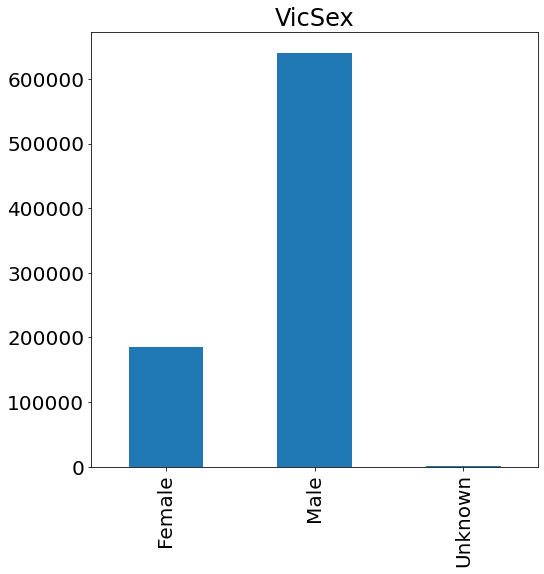

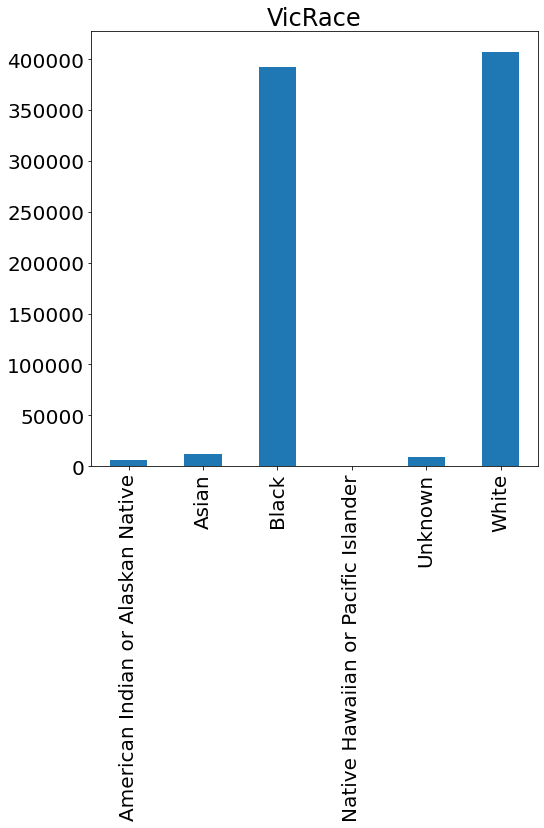

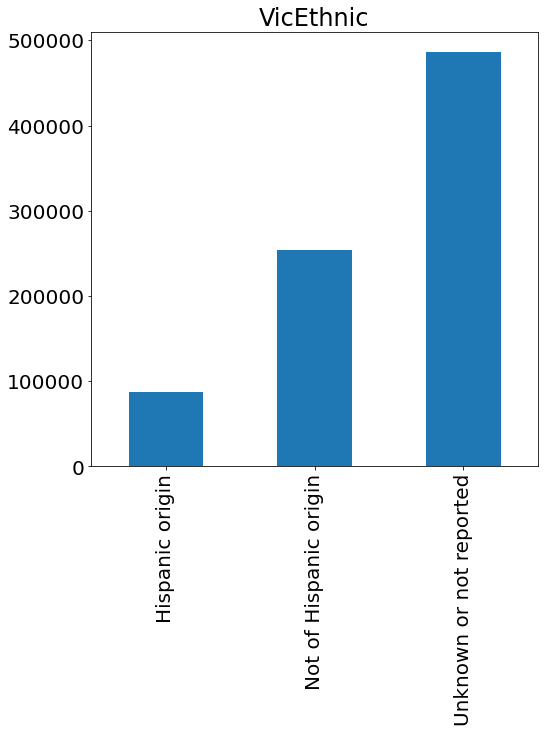

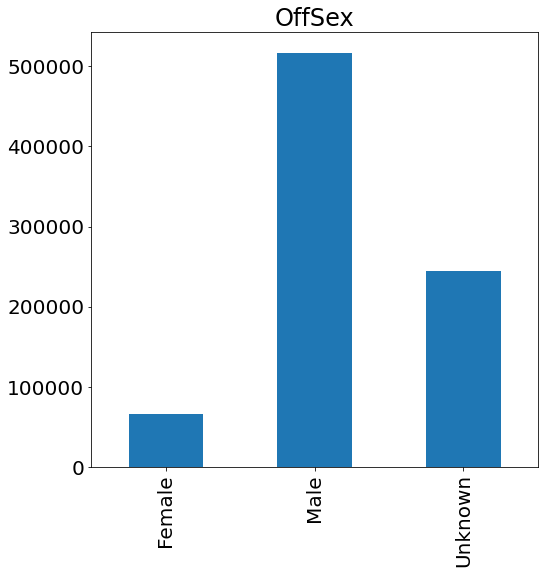

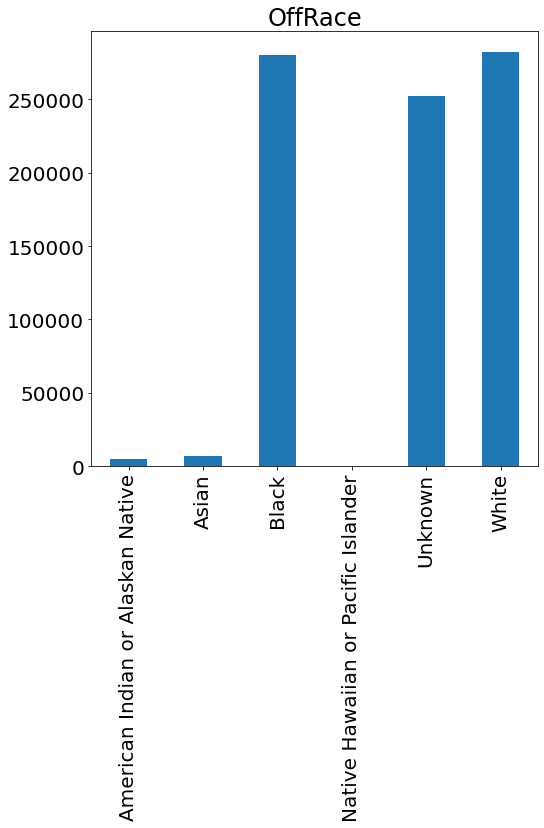

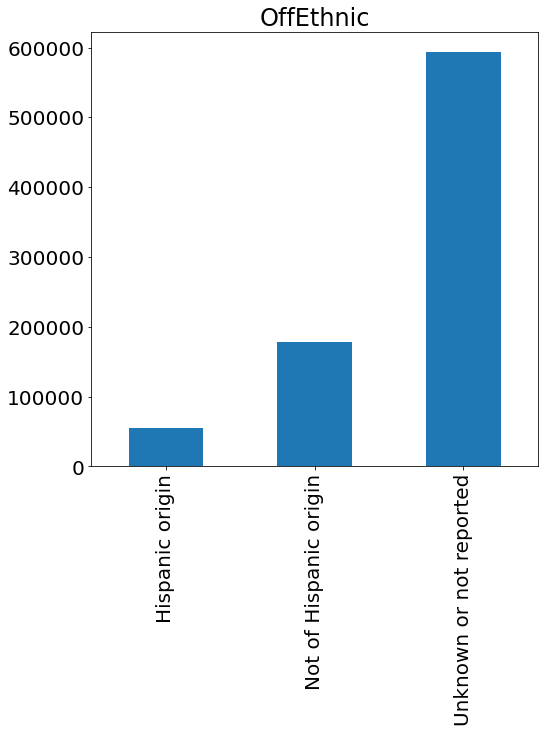

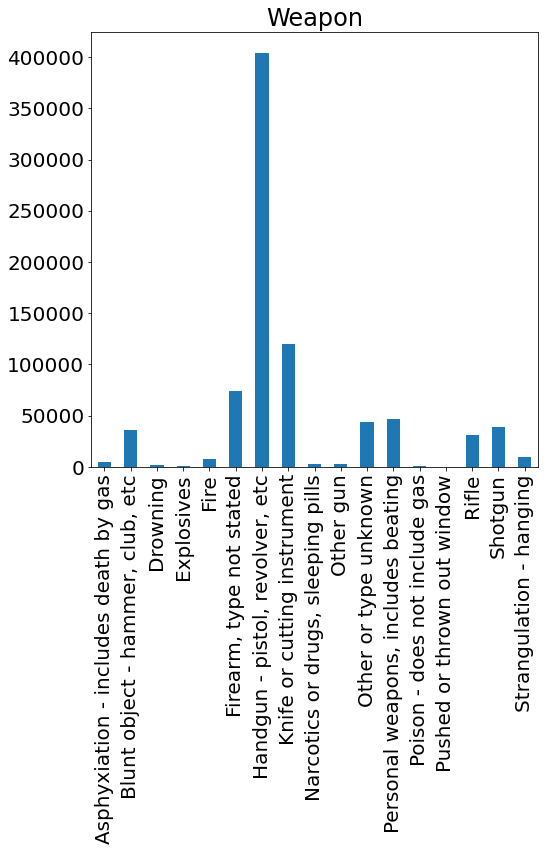

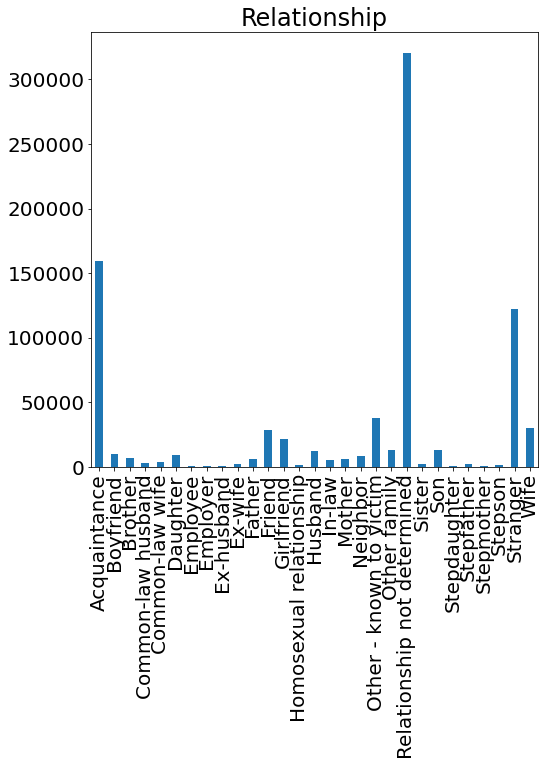

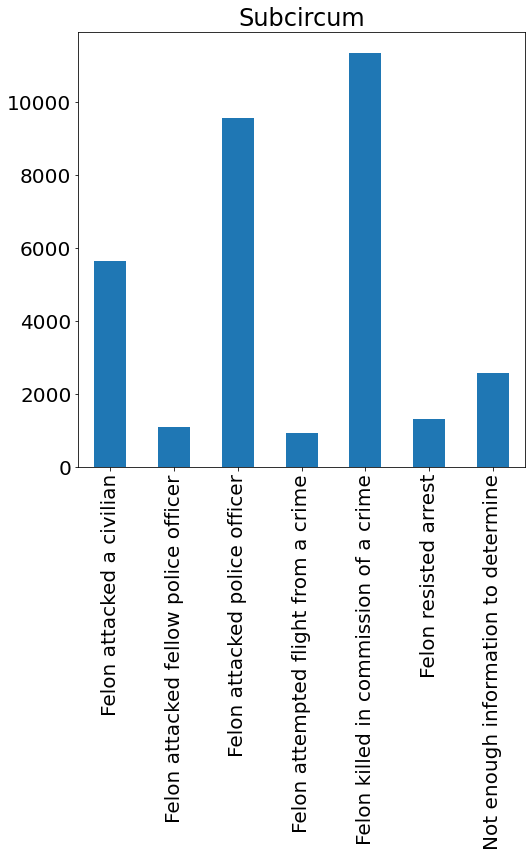

In [143]:
aug_df = pd.DataFrame()
for var in df.columns:
    if df[var].dtypes == 'int64':
        aug_df[var] = df[var]
    elif len(df[var].value_counts()) <= 30 and var in to_print:
        dummies = pd.get_dummies(df[var],prefix=var)
        aug_df = pd.concat([aug_df, dummies], axis=1)
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(1, 1, 1)
        df[var].value_counts().sort_index().plot.bar()
        plt.title(var)
        

In [144]:
all_corrs = aug_df.corr()

all_corrs_list = []
i = 0;
for col in all_corrs.columns:
    i+=1;
    for row in all_corrs.index[i:]:
        a ="Unknown" not in col
        b ="Unknown" not in row
        if a and b: 
            all_corrs_list.append((col, row, abs(all_corrs[col][row])))
        
sorted_list = list(sorted(all_corrs_list,key = lambda i: i[2]))

In [145]:
print("See if there are any redundant variables")
for i in range(6,30):
    print(sorted_list[len(sorted_list)-i])

See if there are any redundant variables
('Agentype_Municipal police', 'Agentype_Sheriff', 0.8387650468348202)
('Solved_Yes', 'OffSex_Male', 0.8346409146198623)
('Solved_No', 'OffSex_Male', 0.8346409146198623)
('Solved_Yes', 'Relationship_Relationship not determined', 0.7170725094309313)
('Solved_No', 'Relationship_Relationship not determined', 0.7170725094309313)
('VicEthnic_Not of Hispanic origin', 'OffEthnic_Not of Hispanic origin', 0.6964099806054052)
('VicRace_White', 'OffRace_White', 0.5863904669855944)
('VicEthnic_Hispanic origin', 'OffEthnic_Hispanic origin', 0.5822980614911275)
('OffSex_Male', 'Relationship_Relationship not determined', 0.5691548443567505)
('VicRace_Black', 'OffRace_White', 0.5677466510340524)
('VicRace_Black', 'OffRace_Black', 0.5167789543723189)
('OffRace_Black', 'OffRace_White', 0.5153866733139904)
('VicRace_American Indian or Alaskan Native', 'OffRace_American Indian or Alaskan Native', 0.49647680579595754)
('VicRace_White', 'OffRace_Black', 0.486182677950

In [146]:
print("Discrete variables :")
print(df.dtypes[df.dtypes == "object"])
print("missing values: ")
print(df[:].isnull().sum().sort_values(ascending = False))

Discrete variables :
County          object
File Month      object
File Day        object
File Year       object
State           object
Agency          object
Area            object
Agentype        object
Source          object
Solved          object
Month           object
ActionType      object
Homicide        object
VicSex          object
VicRace         object
VicEthnic       object
OffSex          object
OffRace         object
OffEthnic       object
Weapon          object
Relationship    object
Circumstance    object
Subcircum       object
dtype: object
missing values: 
Subcircum       794768
OffAge          274871
File Month        2510
File Day          2510
File Year         2510
OffCount             0
ActionType           0
State                0
Agency               0
Area                 0
Agentype             0
Source               0
Solved               0
Year                 0
Month                0
Homicide             0
VicCount             0
VicAge               0
VicSe

In [147]:
print((df[:]=="Unknown").sum().sort_values(ascending =False))

OffRace         252163
OffSex          244299
VicRace           9355
VicSex            1399
Agency               1
OffCount             0
Month                0
File Month           0
File Day             0
File Year            0
State                0
Area                 0
Agentype             0
Source               0
Solved               0
Year                 0
Homicide             0
ActionType           0
VicCount             0
VicAge               0
VicEthnic            0
OffAge               0
OffEthnic            0
Weapon               0
Relationship         0
Circumstance         0
Subcircum            0
County               0
dtype: int64


In [148]:
sums =[]
missing_vars = []
for v in df.columns:
    this_sum = int(df[v].isnull().sum())
    try:
        unk=sum(df[v].str.contains("nknown|undetermined|not specified",regex = True))
        if not np.isnan(unk):
            this_sum+=unk
    except: 
        a=0
    sums.append(this_sum)
    
missing_vars = pd.Series(index = df.columns, data =sums)

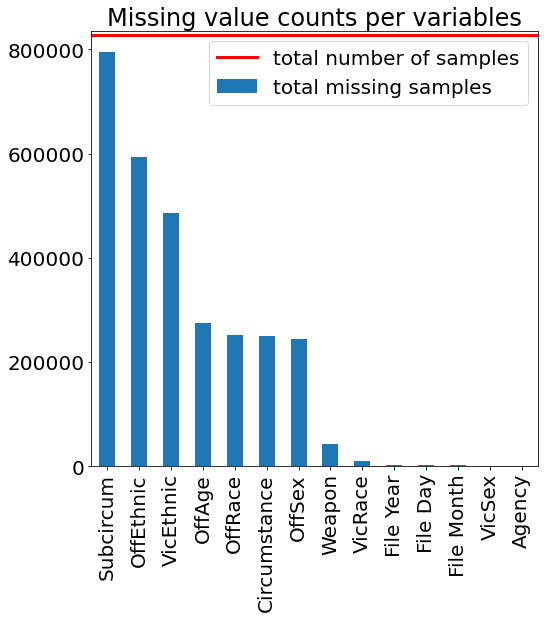

In [149]:
fig = plt.figure(figsize=(8,8))
missing_vars[missing_vars>0].sort_values(ascending = False).plot.bar(label = "total missing samples")
plt.axhline(y=len(df),linewidth=3, color='r', linestyle='-', label = "total number of samples")
plt.title("Missing value counts per variables")
plt.legend()
plt.rcParams['font.size'] = 30


In [150]:
# df_sub = df.drop(["Subcircum","OffEthnic","VicEthnic"],axis = 1)
df_sub = df

print(len(df_sub))
df_sub_full = df_sub.dropna()
print(len(df_sub_full))

for col in df_sub.columns:
    try:
        df_sub_full = df_sub_full[df_sub_full[col].str.contains("nknown|undetermined|not specified",regex = True)==False]
    except:
            a=0
print(len(df_sub_full))


827219
27219
12786


In [151]:
df_sub_full.to_csv('non_empty_sample.csv')

In [152]:
df_miss = df_sub.drop(df_sub_full.index)

In [157]:
print(len(df_miss))

814430


In [154]:
df_miss.to_csv('missing_sample.csv')